# NBA mid-season trades: Causal inference of a trade's effect on a player's performance

Do NBA mid-season player trades actually benefit the players, or not? This topic recently got attention after the controversial trade of Luka Doncic to the LA Lakers without his desire. In this work, I attempt to answer this question with the tools of causal inference.

Using 20 seasons of NBA data from 2003-04 to 2022-23, I estimate the effect of a mid-season trade on a player's performance by looking at traded players performance change, compared to non-traded players.

## 0. Data loading & processing, feauture engineering

Data was collected from the NBA.com website using the `nba_api` package. The process of data collection is in the `data_fetching.ipynb` notebook.

### 0-a) Loading the data

Let's load the data and take a look at it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

import plotting

In [2]:
bios_df = pd.read_csv('data\player_bios.csv')
career_df = pd.read_csv('data\career_filtered.csv')
bios_df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,PLAYER_HEIGHT,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,COLLEGE,COUNTRY,...,PTS,REB,AST,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,AST_PCT,SEASON_ID
0,1630639,A.J. Lawson,1610612742,DAL,22.0,6-6,78.0,179.0,South Carolina,Canada,...,56,21,2,-20.1,0.046,0.152,0.189,0.589,0.032,2022-23
1,1631260,AJ Green,1610612749,MIL,23.0,6-5,77.0,190.0,Northern Iowa,USA,...,154,45,22,-4.9,0.016,0.105,0.159,0.607,0.092,2022-23
2,1631100,AJ Griffin,1610612737,ATL,19.0,6-6,78.0,220.0,Duke,USA,...,639,153,73,1.5,0.026,0.080,0.174,0.577,0.070,2022-23
3,203932,Aaron Gordon,1610612743,DEN,27.0,6-8,80.0,235.0,Arizona,USA,...,1109,446,203,12.1,0.086,0.136,0.206,0.617,0.129,2022-23
4,1628988,Aaron Holiday,1610612737,ATL,26.0,6-0,72.0,185.0,UCLA,USA,...,247,74,89,0.9,0.028,0.059,0.129,0.528,0.135,2022-23


### 0-b) Explanation of attributes: 

|Attribute|Meaning|Extra info|
|---|---|---|
|MIN|minutes   |   |
|FG, FG3, FT|Field goal (2 point goals), field goal 3 pointers, free throws ("penalty throws", 1 point)-  |M: Made (scored), A: attempted, PCT: percentage    |
| REB  |Rebounds   |OREB/DREB: Offensive/defensive rebound  |
|AST|Assists   |AST_PCT: Assist percentage   |
|STL|Steals   |   |
|BLK|Blocks   |   |
|TOV|Turnovers   | Negative statistic  |
|PF|Personal fouls   | Negative statistic  |
|PTS|Points   |   |
|---|--------------------------------------------------------| --------------------------------------------------------------  |
|DRAFT|Each year before the season starts, 60(?) college newcomers can be drafted by teams   |More "promising" players are drafted in earlier rounds   |
|GP, GS|Games played, games started   |   |
|NET_RATING|Offensive rating - defensive rating   |For a player: measure for how many goals a team scores with him vs. allow in. Can be negative.   |
|USG_PCT|Usage percentage   | Estimate of percentage of team plays    |
|TS_PCT|True shooting percentage   | Measures how well a player shoots-  |


### 0-c) Sorting, selecting

As a first step, drop the few duplicate rows, and the incorrent team ID rows:

In [3]:
career_df = career_df.drop_duplicates()
career_df = career_df[career_df['TEAM_ID']!=0].reset_index(drop=True)

Let's only select players (unique ID) from both data - this is just over 2000 players.

In [4]:
ids_bio = bios_df['PLAYER_ID'].unique()
ids_career = career_df['PLAYER_ID'].unique()
ids = np.intersect1d(ids_bio, ids_career)
seasons = ["2022-23","2021-22","2020-21",'2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14','2012-13', '2011-12', '2010-11', '2009-10', '2008-09','2007-08', '2006-07', '2005-06', '2004-05', '2003-04',]

career_df = career_df[career_df['PLAYER_ID'].isin(ids)]
bios_df = bios_df[bios_df['PLAYER_ID'].isin(ids)]
len(ids)

2074

Add new columns: `TREATMENT` (1 if traded, 0 if not), `AFTER_N_MIDSEASON_TRADES` (N after N amount of mid-season trades), `AFTER_N_START_OF_SEASON_TRADES` (N after N amount of end-of-season trades).

It's better to drop the players who somehow played for 3+ teams in a season.

In [5]:
bad_ids = list(career_df.groupby(['PLAYER_ID', 'SEASON_ID']).filter(lambda x: len(x) >= 3)['PLAYER_ID'].unique())
career_df = career_df[~career_df['PLAYER_ID'].isin(bad_ids)]

In [6]:
def identify_before_after_teams(player, year, df=career_df, id_column='PLAYER_ID', team_column='TEAM_ID', year_column='YEAR'):
    """Identify which team is the 'before' and which is the 'after' team of a player, after a midseason trade."""
    player_df = df[(df[id_column] == player)]
    years = sorted(player_df[year_column].unique())
    year_index = list(years).index(year)
    previous_year = years[year_index - 1] if year_index > 0 else None
    next_year = years[year_index + 1] if year_index < len(years) - 1 else None
    teams_in_year = player_df[player_df[year_column] == year][team_column].unique()
    
    if len(teams_in_year) != 2:
        print(f"Player {player} in year {year} has {len(teams_in_year)} teams, expected 2")
        return {'before': teams_in_year[0], 'after': teams_in_year[1]}
    
    #Try determine from previous year
    if previous_year is not None:
        previous_teams = player_df[player_df[year_column] == previous_year][team_column].unique()
        for team in teams_in_year:
            if team in previous_teams:
                return {'before': team, 'after': [t for t in teams_in_year if t != team][0]}
    
    #Try based on next year
    if next_year is not None:
        next_teams = player_df[player_df[year_column] == next_year][team_column].unique()
        for team in teams_in_year:
            if team in next_teams:
                return {'before': [t for t in teams_in_year if t != team][0], 'after': team}
                
    #print(f"Could not determine before/after teams for player {player} in year {year}")
    return {'before': teams_in_year[0], 'after': teams_in_year[1]}  # Arbitrary choice

def get_player_yearly_teams(player, df = career_df, id_column = 'PLAYER_ID', team_column ='TEAM_ID', year_column = 'YEAR'):
    player_df = df[df[id_column] == player][[id_column, team_column, year_column]].copy()
    years = player_df[year_column].unique()
    year_teams = {}
    for year in years:
        year_teams[year] = player_df[player_df[year_column] == year][team_column].unique()
    return year_teams

def get_player_mid_season_trades(player, df = career_df, id_column = 'PLAYER_ID', team_column ='TEAM_ID', year_column = 'YEAR', before_after = False):
    #assuming every player has at most one trade per year
    player_df = df[df[id_column] == player][[id_column, year_column]].copy()
    years = player_df[year_column].unique()
    years_midseason_trades = []
    for year in years:
        if len(player_df[player_df[year_column] == year]) > 1:
            if before_after:
                teams = identify_before_after_teams(player, year, df, id_column, team_column = team_column, year_column = year_column)
                before = teams['before']
                after = teams['after']
                years_midseason_trades.append({year: {'before': before, 'after': after}})
            else:
                years_midseason_trades.append(year)
    return years_midseason_trades

def get_player_start_of_season_trades(player, df = career_df, id_column = 'PLAYER_ID', team_column ='TEAM_ID', year_column = 'YEAR'):
    #assuming every player has at most one trade per year
    player_df = df[df[id_column] == player].copy()
    years = sorted(player_df[year_column].unique())
    years_endseason_trades = []
    previous_year = years[0]
    yearly_teams = get_player_yearly_teams(player, player_df, id_column, year_column = year_column, team_column = team_column)
    for year in years[1:]:
        previous_teams = yearly_teams[previous_year]
        current_teams = yearly_teams[year]
        if len(set(previous_teams).intersection(set(current_teams))) == 0:
            years_endseason_trades.append(year)
        previous_year = year
    return years_endseason_trades

def get_player_trades(player, df = career_df, id_column = 'PLAYER_ID', year_column = 'YEAR'):
    mid_season_trades = get_player_mid_season_trades(player, df, id_column, year_column = year_column,
                                                     team_column = 'TEAM_ABBREVIATION', before_after = True)
    start_of_season_trades = get_player_start_of_season_trades(player, df, id_column, year_column = year_column, team_column = 'TEAM_ABBREVIATION')
    trades = {'midseason': mid_season_trades, 'startseason': start_of_season_trades}
    return trades

def set_player_trade_columns(df=career_df, id_column='PLAYER_ID', year_column='YEAR',
                             mid_season_col='AFTER_N_MIDSEASON_TRADES', start_of_season_col='AFTER_N_START_OF_SEASON_TRADES'):
    #AFTER_N_MIDSEASON_TRADES (N after N amount of mid-season trades), AFTER_N_START_OF_SEASON_TRADES (N after N amount of trades after the end of a season).
    df = df.copy()
    df.loc[:, mid_season_col] = 0
    df.loc[:, start_of_season_col] = 0

    for player in df[id_column].unique():
        player_df = df[df[id_column] == player]
        trades = get_player_trades(player, player_df, id_column, year_column)

        if trades['startseason']:
            for year in trades['startseason']:
                df.loc[(df[id_column] == player) & (df[year_column] >= year), start_of_season_col] += 1
        if trades['midseason']:
            for year_dict in trades['midseason']:
                year = list(year_dict.keys())[0]
                df.loc[(df[id_column] == player) & (df[year_column] >= year), mid_season_col] += 1

                before_team = year_dict[year]['before']
                df.loc[(df[id_column] == player) & (df[year_column] == year) & (df['TEAM_ABBREVIATION'] == before_team), mid_season_col] -= 1

    return df

career_df['YEAR'] = career_df['SEASON_ID'].str[:4].astype(int)
mid_season_col='AFTER_N_MIDSEASON_TRADES'
start_of_season_col='AFTER_N_START_OF_SEASON_TRADES'
career_df.loc[:, mid_season_col] = 0
career_df.loc[:, start_of_season_col] = 0

players_mid_season_trade_years = {}
for player_id in career_df['PLAYER_ID'].unique():
    mid_season_trade_years = get_player_mid_season_trades(player_id)
    players_mid_season_trade_years[player_id] = mid_season_trade_years
career_df = set_player_trade_columns(career_df)
treatment_players = career_df[career_df[mid_season_col] > 0]['PLAYER_ID'].unique()
career_df['TREATMENT'] = career_df['PLAYER_ID'].apply(lambda x: 1 if x in treatment_players else 0)
career_df['TRADED_THIS_SEASON'] = career_df.apply(lambda x: 1 if x['YEAR'] in players_mid_season_trade_years[x['PLAYER_ID']] else 0, axis=1)

In [7]:
cols = ['PLAYER_ID', 'SEASON_ID', 'YEAR', 'TEAM_ABBREVIATION', 'TREATMENT',
        'AFTER_N_MIDSEASON_TRADES', 'AFTER_N_START_OF_SEASON_TRADES', 'TRADED_THIS_SEASON',
        'PLAYER_AGE', 'GP', 'GS', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
        'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
        'BLK', 'TOV', 'PF', 'TEAM_ID', 'LEAGUE_ID', ]
career_df = career_df[cols]

In [8]:
career_df[career_df["PLAYER_ID"] == 57]

,PLAYER_ID,SEASON_ID,YEAR,TEAM_ABBREVIATION,TREATMENT,AFTER_N_MIDSEASON_TRADES,AFTER_N_START_OF_SEASON_TRADES,TRADED_THIS_SEASON,PLAYER_AGE,GP,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,TEAM_ID,LEAGUE_ID
10179,57,2003-04,2003,SAC,1,0,0,0,34.0,82,...,69.0,260.0,329.0,347,151.0,41.0,155.0,186,1610612758,0
10180,57,2004-05,2004,SAC,1,0,0,1,35.0,31,...,29.0,94.0,123.0,153,43.0,13.0,68.0,61,1610612758,0
10181,57,2004-05,2004,ORL,1,1,0,1,35.0,21,...,9.0,45.0,54.0,46,37.0,5.0,36.0,45,1610612753,0
10182,57,2005-06,2005,DAL,1,1,1,0,36.0,7,...,2.0,11.0,13.0,14,9.0,1.0,6.0,10,1610612742,0
10183,57,2006-07,2006,LAC,1,1,2,0,37.0,7,...,3.0,8.0,11.0,8,3.0,1.0,5.0,11,1610612746,0


These are the stats for Player 57: statistics from multiple seasons.<br>
The players that have multiple rows for the same season (e.g. see 2004-05 above) were playing in different teams in the same season - hence being in the treatment group.

Okay. It's better to filter out seasonal data that had too low playtime, they are not averaged well.<br>
Filter out low minute data for accuracy: all seasonal stats with less than 3 matches played

### 0-d) Normalizing by minutes played

Consideration: should we use raw stats, or normalized by minutes/age/etc.?

Firstly, a crucial factor must be the minutes played. The more you play, the more you score. Let's see:

In [9]:
point_means = []; min_means = []; fg_pct_means = [];  three_pct_means = []; ft_pct_means = [];
ages = sorted(career_df['PLAYER_AGE'].unique()) #18-44
treatment_means = []
mid_season_trades_means = []
start_of_season_trades_means = []

for age in ages:
    point_means.append(career_df[career_df['PLAYER_AGE'] == age]['PTS'].mean())
    min_means.append(career_df[career_df['PLAYER_AGE'] == age]['MIN'].mean())
    fg_pct_means.append(career_df[career_df['PLAYER_AGE'] == age]['FG_PCT'].mean())
    three_pct_means.append(career_df[career_df['PLAYER_AGE'] == age]['FG3_PCT'].mean())
    ft_pct_means.append(career_df[career_df['PLAYER_AGE'] == age]['FT_PCT'].mean())
    treatment_means.append(career_df[career_df['PLAYER_AGE'] == age]['TREATMENT'].mean())
    mid_season_trades_means.append(career_df[career_df['PLAYER_AGE'] == age][mid_season_col].mean())
    start_of_season_trades_means.append(career_df[career_df['PLAYER_AGE'] == age][start_of_season_col].mean())

Strong correlation in performance and minutes played (only one statistic is shown, but true in general):

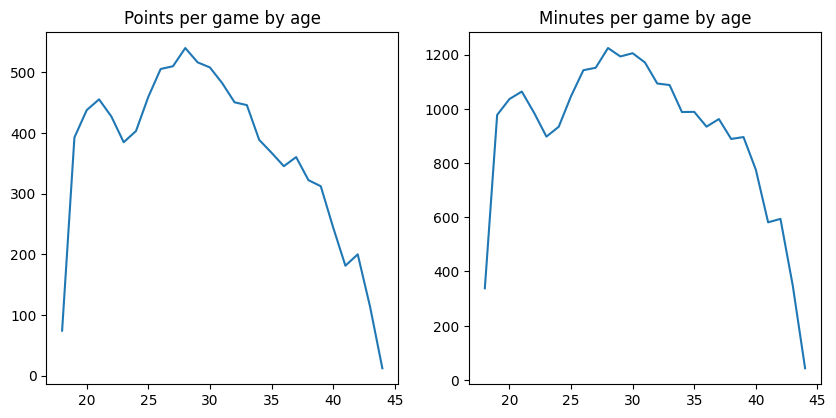

In [10]:
fig, ax = plt.subplots(nrows=1 ,ncols=2, figsize=(10, 6))
sns.lineplot(x=ages, y=point_means, ax=ax[0])
sns.lineplot(x=ages, y=min_means, ax=ax[1])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[0].set_title('Points per game by age')
ax[1].set_title('Minutes per game by age');

Obviously we have to adjust most measures, normalizing by minutes. <br>

In the meantime we can check 'FG_PCT', 'FG3_PCT', and 'FT_PCT' as they are already normalized:

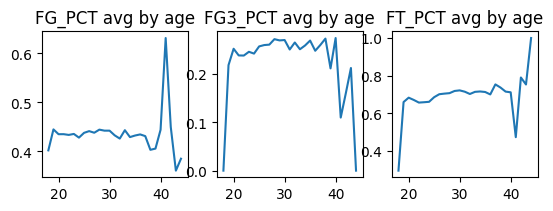

In [11]:
fig, ax = plt.subplots(nrows=1 ,ncols=3, )
sns.lineplot(x=ages, y=fg_pct_means, ax=ax[0])
sns.lineplot(x=ages, y=three_pct_means, ax=ax[1])
sns.lineplot(x=ages, y=ft_pct_means, ax=ax[2])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[2].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')
ax[0].set_title('FG_PCT avg by age')
ax[1].set_title('FG3_PCT avg by age')
ax[2].set_title('FT_PCT avg by age');

Aside from "very young" and "very old" players, the age seems to matter little in scoring. 

In the treatment group and trades, obviously age plays a role:

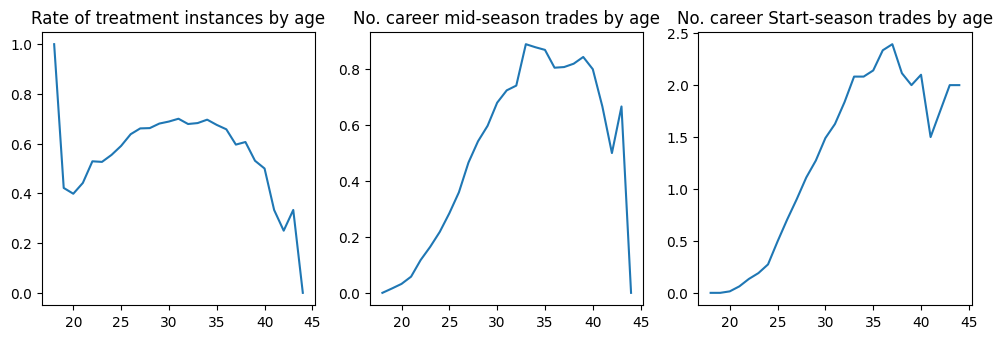

In [12]:
fig, ax = plt.subplots(nrows=1 ,ncols=3, figsize=(12, 4))
sns.lineplot(x=ages, y=treatment_means, ax=ax[0])
sns.lineplot(x=ages, y=mid_season_trades_means, ax=ax[1])
sns.lineplot(x=ages, y=start_of_season_trades_means, ax=ax[2])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[2].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')
ax[0].set_title('Rate of treatment instances by age')
ax[1].set_title('No. career mid-season trades by age')
ax[2].set_title('No. career Start-season trades by age');

Let's just normalize by minutes, drop no instances.

In [13]:
def normalize_by_min(df=career_df, cols=career_df.columns, mins=career_df['MIN']):
    for col in cols:
        df[col] = df[col]/mins
        df = df.rename(columns={col: col + '_PM'})
    return df

norm_cols = ['PTS', 'AST', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'STL',
             'BLK', 'TOV', 'PF', ]
career_df["MIN_PG"] =career_df["MIN"] / career_df["GP"]
career_df["PTS_PG"] =career_df["PTS"] / career_df["GP"]
career_df = normalize_by_min(career_df, cols=norm_cols, mins=career_df['MIN'])
#career_df["AST_PG"] =career_df["AST"] / career_df["GP"]
career_df.head()

,PLAYER_ID,SEASON_ID,YEAR,TEAM_ABBREVIATION,TREATMENT,AFTER_N_MIDSEASON_TRADES,AFTER_N_START_OF_SEASON_TRADES,TRADED_THIS_SEASON,PLAYER_AGE,GP,...,REB_PM,AST_PM,STL_PM,BLK_PM,TOV_PM,PF_PM,TEAM_ID,LEAGUE_ID,MIN_PG,PTS_PG
0,949,2003-04,2003,ATL,1,0,0,1,27.0,53,...,0.253197,0.064962,0.022506,0.009719,0.067008,0.075192,1610612737,0,36.886792,20.094340
1,949,2003-04,2003,POR,1,1,0,1,27.0,32,...,0.197531,0.064472,0.032922,0.024691,0.072702,0.102881,1610612757,0,22.781250,9.968750
2,949,2004-05,2004,POR,1,1,0,0,28.0,54,...,0.209850,0.059422,0.026231,0.013919,0.062634,0.080300,1610612757,0,34.592593,16.833333
3,949,2005-06,2005,SAC,1,1,1,0,29.0,72,...,0.182050,0.075982,0.024477,0.021418,0.055074,0.115757,1610612758,0,27.236111,12.319444
4,949,2006-07,2006,SAC,1,1,1,0,30.0,80,...,0.197519,0.054094,0.026303,0.019851,0.057568,0.120596,1610612758,0,25.187500,9.912500


Great. We do not need to change the biography data, let's "perfectly" combine the two datasets:

In [14]:
ids_bio = bios_df['PLAYER_ID'].unique()
ids_career = career_df['PLAYER_ID'].unique()
ids = np.intersect1d(ids_bio, ids_career)

bios_df_ = bios_df[bios_df['PLAYER_ID'].isin(ids) ].reset_index(drop=True)
career_df_ = career_df[career_df['PLAYER_ID'].isin(ids) ].reset_index(drop=True)

#Find all common id-season pairs
id_season_pairs_bio = (bios_df_[['PLAYER_ID', 'SEASON_ID']].to_numpy().tolist())
id_season_pairs_career = career_df_[['PLAYER_ID', 'SEASON_ID']].to_numpy().tolist()
A = set(tuple(x) for x in id_season_pairs_bio); B = set(tuple(x) for x in id_season_pairs_career)
id_season_pairs = ([x for x in A & B])


bios_df_ = bios_df_[bios_df_[['PLAYER_ID', 'SEASON_ID']].apply(tuple, axis=1).isin(id_season_pairs) ].reset_index(drop=True)
bios_df_ = bios_df_.drop(columns=['TEAM_ID', 'TEAM_ABBREVIATION',]).rename(columns={'GP': 'GP_SEASON', 'PTS': 'PTS_SEASON', 'REB': 'REB_SEASON',
                                                                                    'AST': 'AST_SEASON', 'OREB_PCT': 'OREB_PCT_SEASON',
                                                                                    'DREB_PCT': 'DREB_PCT_SEASON', 'USG_PCT': 'USG_PCT_SEASON',
                                                                                    'TS_PCT': 'TS_PCT_SEASON', 'AST_PCT': 'AST_PCT_SEASON',
                                                                                    'NET_RATING': 'NET_RATING_SEASON'})
career_df_ = career_df_[career_df_[['PLAYER_ID', 'SEASON_ID']].apply(tuple, axis=1).isin(id_season_pairs) ].reset_index(drop=True)
data = pd.merge(career_df_, bios_df_, on=['PLAYER_ID', 'SEASON_ID'], how='inner')
data = (data.drop(columns=['PLAYER_AGE'])).dropna().reset_index(drop=True)
data.head()

,PLAYER_ID,SEASON_ID,YEAR,TEAM_ABBREVIATION,TREATMENT,AFTER_N_MIDSEASON_TRADES,AFTER_N_START_OF_SEASON_TRADES,TRADED_THIS_SEASON,GP,GS,...,GP_SEASON,PTS_SEASON,REB_SEASON,AST_SEASON,NET_RATING_SEASON,OREB_PCT_SEASON,DREB_PCT_SEASON,USG_PCT_SEASON,TS_PCT_SEASON,AST_PCT_SEASON
0,949,2003-04,2003,ATL,1,0,0,1,53,53,...,85,1384,639,174,-2.4,0.074,0.163,0.244,0.557,0.126
1,949,2003-04,2003,POR,1,1,0,1,32,3,...,85,1384,639,174,-2.4,0.074,0.163,0.244,0.557,0.126
2,949,2004-05,2004,POR,1,1,0,0,54,49,...,54,909,392,111,-5.7,0.069,0.143,0.216,0.581,0.106
3,949,2005-06,2005,SAC,1,1,1,0,72,30,...,72,887,357,149,4.4,0.057,0.133,0.199,0.588,0.130
4,949,2006-07,2006,SAC,1,1,1,0,80,45,...,80,793,398,109,-4.4,0.062,0.148,0.194,0.524,0.092


### 0-d) What attributes might be relevant? (& feature engineering)

Let's go through all categories, and consider their relationship to `x` (being traded) and `y` (minutes):

Performance statistics in general: these matter, as they are common causes of being traded and minutes played.

- Age: Can possibly matter, we must include it. Younger players for example might be more likely to be traded, moreover age is related to the amount of minutes played on average (common cause).
- FG, FG3, FT: Performance statistics, so we certainly have to keep some of them.<br>For free throws, attempted free throws likely isn't relevant, scored free throws are also likely not important, rather the percentage, which we can include to make sure. Free throws aren't most key for getting playtime.<br>
With similar reasoning, I keep the field goal and 3-pointer percentages.<br>
- PTS: Including the PTS/per game ratio might also be relevant.<br>
- REB: It is worthy to keep both OREB and DREB. Since we don't have a position attribute, these are fairly good indicators instead and may be important to control on. Directly, they are performance statistics, indirectly they might indicate position.<br>
- BLK, TOV, STL, PF: Performance statistics, let's keep them.<br>
- AST: Point guards typically have high number of assists, centers not - keep it for the reasons that it is a performance statistic, and it might indicate position.<br>

- Height, weight, college, country, draft: Hopefully, these are not relevant in any form. Draft number may be relevant for the reason that earlier picks are the higher rated and typically the better players.<br>
- NET_RATING, USG: They can be useful general performance statistics, the only problem is these are not available. Nonetheless, can help capture reverse causality for example.<br>
- Games played/started: These could be useful to control on for reverse causality, but I will instead use leads.<br>


What else?

- Position: Can play a significant role in minutes played, performance statistics, and arguably correlates with being traded (forwards get traded more often), so is endogeneous to `y`. However, there was no data particularly on which position a player is playing preferably, and I use other attributes to try to indicate this information. (Typically, there are 5 positions: Point guard, Shooting guard, Small forward, Power forward, Center, but some roles are interchangable.)<br>
- Injuries: No data. <br>
- Reverse causality: Playing badly and not playing much can lead to being traded - to control for this, we can use leads
- Lags: It may take time to adjust to a new team, so effect might be delayed -> add lags.<br>
- The number of seasons the player has played.


We can see the relationship between trades and other variables:

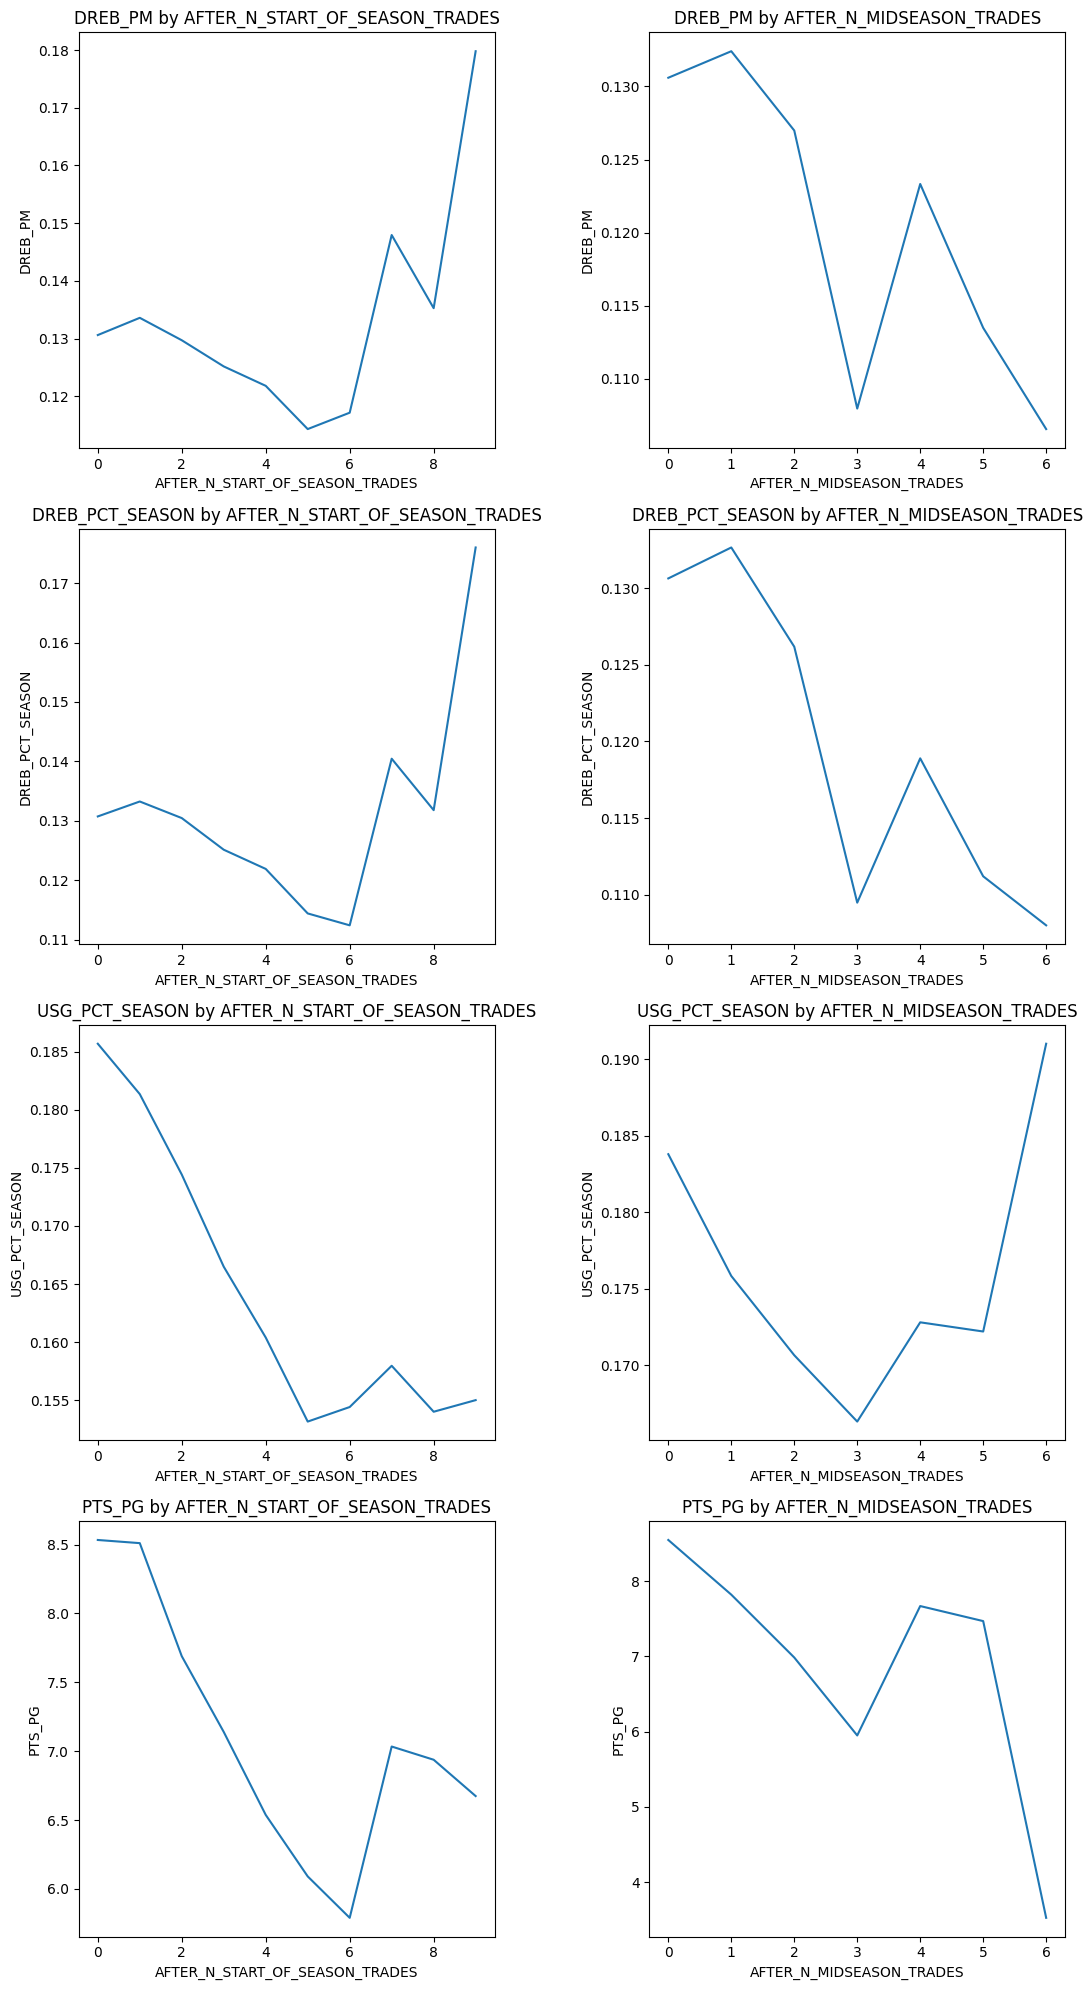

In [15]:
plotting.plot_As_by_Bs_and_Cs(data, As=['DREB_PM', 'DREB_PCT_SEASON', 'USG_PCT_SEASON', 'PTS_PG'], Bs=['AFTER_N_START_OF_SEASON_TRADES']*4, Cs=['AFTER_N_MIDSEASON_TRADES']*4)

Save our data:

In [16]:
data = data.sort_values(['PLAYER_ID', 'SEASON_ID', 'AFTER_N_MIDSEASON_TRADES'], ascending=[True, True, True]).reset_index(drop=True)
data.to_csv('data\data_combined.csv', index=False)

## 2. Models

Let's prepare some new (e.g. lagged) features, and then we can start with the models.

In [17]:
data["AFTER_N_MIDSEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].shift(1)
data["AFTER_N_START_OF_SEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].shift(1)
data["MINS_lag1"] = data.groupby("PLAYER_ID")["MIN"].shift(1)
data["MIN_PG_lag1"] = data.groupby("PLAYER_ID")["MIN_PG"].shift(1)
data["AFTER_N_MIDSEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].shift(2)
data["AFTER_N_START_OF_SEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].shift(2)
#data["MINS_lag2"] = data.groupby("PLAYER_ID")["MIN"].shift(2)
data["NET_RATING_SEASON_lag1"] = data.groupby("PLAYER_ID")["NET_RATING_SEASON"].shift(1)

data["MINS_lead1"] = data.groupby("PLAYER_ID")["MIN"].shift(-1)
data["MIN_PG_lead1"] = data.groupby("PLAYER_ID")["MIN_PG"].shift(-1)
data["AFTER_N_MIDSEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].shift(-1)
data["AFTER_N_START_OF_SEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].shift(-1)

data["d_AFTER_N_MIDSEASON_TRADES"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].diff()
data["d_AFTER_N_START_OF_SEASON_TRADES"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].diff()
data["d_MINS"] = data.groupby("PLAYER_ID")["MIN"].diff()
data["d_MIN_PG"] = data.groupby("PLAYER_ID")["MIN_PG"].diff()

first_years = data.groupby("PLAYER_ID")["YEAR"].min()
data["time_trend"] = data.apply(lambda x: x["YEAR"] - first_years[x["PLAYER_ID"]], axis=1)
data["d_time_trend"] = data.groupby("PLAYER_ID")["time_trend"].diff()

data["d_AFTER_N_MIDSEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["d_AFTER_N_MIDSEASON_TRADES"].shift(1)
data["d_AFTER_N_START_OF_SEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["d_AFTER_N_START_OF_SEASON_TRADES"].shift(1)
data["d_MINS_lag1"] = data.groupby("PLAYER_ID")["d_MINS"].shift(1)
data["d_MIN_PG_lag1"] = data.groupby("PLAYER_ID")["d_MIN_PG"].shift(1)
data["d_AFTER_N_MIDSEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["d_AFTER_N_MIDSEASON_TRADES"].shift(2)
data["d_AFTER_N_START_OF_SEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["d_AFTER_N_START_OF_SEASON_TRADES"].shift(2)
#data["d_MINS_lag2"] = data.groupby("PLAYER_ID")["d_MINS"].shift(2)
data["d_NET_RATING_SEASON_lag1"] = data.groupby("PLAYER_ID")["NET_RATING_SEASON"].shift(1)

data["d_MINS_lead1"] = data.groupby("PLAYER_ID")["d_MINS"].shift(-1)
data["d_MIN_PG_lead1"] = data.groupby("PLAYER_ID")["d_MIN_PG"].shift(-1)
data["d_AFTER_N_MIDSEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["d_AFTER_N_MIDSEASON_TRADES"].shift(-1)
data["d_AFTER_N_START_OF_SEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["d_AFTER_N_START_OF_SEASON_TRADES"].shift(-1)

data["d_AGE"] = data.groupby("PLAYER_ID")["AGE"].diff()
data["d_FG_PCT"] = data.groupby("PLAYER_ID")["FG_PCT"].diff()
data["d_FG3_PCT"] = data.groupby("PLAYER_ID")["FG3_PCT"].diff()
data["d_FT_PCT"] = data.groupby("PLAYER_ID")["FT_PCT"].diff()
data["d_PTS_PG"] = data.groupby("PLAYER_ID")["PTS_PG"].diff()
data["d_AST_PM"] = data.groupby("PLAYER_ID")["AST_PM"].diff()
data["d_DREB_PM"] = data.groupby("PLAYER_ID")["DREB_PM"].diff()
data["d_OREB_PM"] = data.groupby("PLAYER_ID")["OREB_PM"].diff()
data["d_STL_PM"] = data.groupby("PLAYER_ID")["STL_PM"].diff()
data["d_BLK_PM"] = data.groupby("PLAYER_ID")["BLK_PM"].diff()
data["d_TOV_PM"] = data.groupby("PLAYER_ID")["TOV_PM"].diff()
data["d_PF_PM"] = data.groupby("PLAYER_ID")["PF_PM"].diff()
data["d_USG_PCT_SEASON"] = data.groupby("PLAYER_ID")["USG_PCT_SEASON"].diff()
data["d_NET_RATING_SEASON"] = data.groupby("PLAYER_ID")["NET_RATING_SEASON"].diff()

data["d_GP"] = data.groupby("PLAYER_ID")["GP"].diff()
data["d_GS"] = data.groupby("PLAYER_ID")["GS"].diff()

y = 'MIN_PG'
x = 'AFTER_N_MIDSEASON_TRADES'
t = 'time_trend'
x_l1 = 'AFTER_N_MIDSEASON_TRADES_lag1'
x_l2 = 'AFTER_N_MIDSEASON_TRADES_lag2'
y_le1 = 'MIN_PG_lead1'
x_le1 = 'AFTER_N_MIDSEASON_TRADES_lead1'
z1 = 'AGE'
z2 = 'FG_PCT'
z3 = 'FG3_PCT'
z4 = 'FT_PCT'
z5 = 'PTS_PG'
z6 = 'AST_PM'
z7 = 'DREB_PM'
z8 = 'OREB_PM'
z9 = 'STL_PM'
z10 = 'BLK_PM'
z11 = 'TOV_PM'
z12 = 'PF_PM'
z13 = 'NET_RATING_SEASON'
z14 = 'NET_RATING_SEASON_lag1'

dy = 'd_MIN_PG'
dx = 'd_AFTER_N_MIDSEASON_TRADES'
dt = "d_time_trend"
dx_l1 = 'd_AFTER_N_MIDSEASON_TRADES_lag1'
dx_l2 = 'd_AFTER_N_MIDSEASON_TRADES_lag2'
dy_le1 = 'd_MIN_PG_lead1'
dx_le1 = 'd_AFTER_N_MIDSEASON_TRADES_lead1'
dz1 = 'd_AGE'
dz2 = 'd_FG_PCT'
dz3 = 'd_FG3_PCT'
dz4 = 'd_FT_PCT'
dz5 = 'd_PTS_PG'
dz6 = 'd_AST_PM'
dz7 = 'd_DREB_PM'
dz8 = 'd_OREB_PM'
dz9 = 'd_STL_PM'
dz10 = 'd_BLK_PM'
dz11 = 'd_TOV_PM'
dz12 = 'd_PF_PM'
dz13 = 'd_NET_RATING_SEASON'
dz14 = 'd_NET_RATING_SEASON_lag1'

diff_attr_confounders = [dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10, dz11, dz12, dz13, #dz14
                    ]
confounders = [dt, dx_l1, dx_l2, dy_le1] + diff_attr_confounders

### 2-a) Check outliers

There are some outliers in the data, where before or after the trade, the player played significantly more matches than half a season amount. The amount of matches in a season is 82 + few special matches, on average 41 per half season, the mid-season trade window can change this for a player by about $\pm$ 10-12 matches (if they sign at the very beginning of the window, they most likely did not play more than 41-12=29 matches so far that season).

We can filter out very high difference values from the treatment group.

In [18]:
data_intervention = data[data["TRADED_THIS_SEASON"] == 1]
data_intervention.loc[:,'AFTER']= data_intervention.groupby(["PLAYER_ID","SEASON_ID"])['AFTER_N_MIDSEASON_TRADES'].diff().replace({np.nan: 0})

before_cases = data_intervention[data_intervention["AFTER"] == 0]
after_cases = data_intervention[data_intervention["AFTER"] == 1]
before_mean = before_cases["MIN_PG"].mean()
after_mean = after_cases["MIN_PG"].mean()

c:\Users\hanic\miniforge3\envs\da4_case\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\hanic\miniforge3\envs\da4_case\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Let's check out the distribution of matches played (and minutes per game) for both groups:

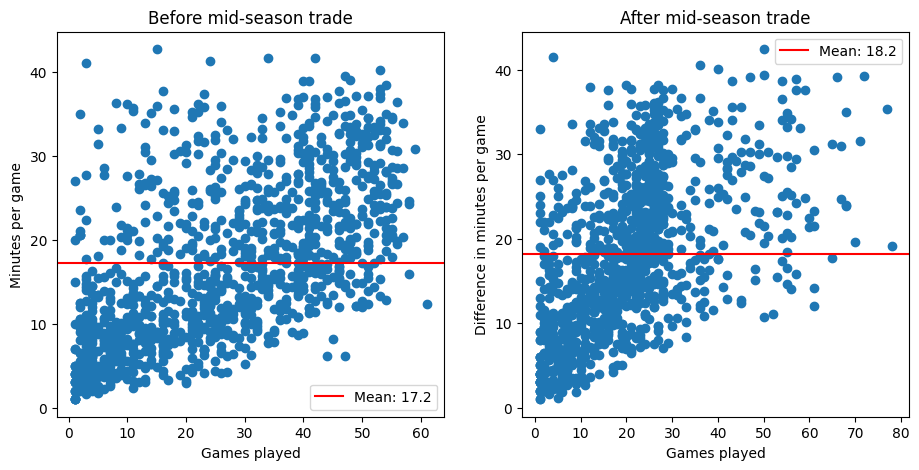

In [19]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.scatter(before_cases["GP"], before_cases["MIN_PG"])
plt.xlabel("Games played")
plt.ylabel("Minutes per game")
plt.title("Before mid-season trade")
plt.axhline(y=before_mean, color='r', linestyle='-', label=f'Mean: {before_mean:.1f}')
plt.legend();

plt.subplot(1, 2, 2)
plt.scatter(after_cases["GP"], after_cases["MIN_PG"])
plt.xlabel("Games played")
plt.ylabel("Difference in minutes per game")
plt.title("After mid-season trade")
plt.axhline(y=after_mean, color='r', linestyle='-', label=f'Mean: {after_mean:.1f}')

plt.legend();

Already we see the average increase by 1 minute. However, we see outliers, mostly in the after trade group, some even played ~80 matches, these must be non-mid-season trades. Let's filter out these:

In [20]:
too_active_players = data_intervention.groupby(['PLAYER_ID', 'SEASON_ID']).filter(lambda x: (x['GP'] > 55).any())['PLAYER_ID'].unique()
data_intervention = data_intervention[~data_intervention['PLAYER_ID'].isin(too_active_players)]

In [21]:
before_cases = data_intervention[data_intervention["AFTER"] == 0]
after_cases = data_intervention[data_intervention["AFTER"] == 1]
before_mins_mean = before_cases["MIN_PG"].mean()
after_mins_mean = after_cases["MIN_PG"].mean()
d_mins_mean = after_mins_mean - before_mins_mean
before_games_mean = before_cases["GP"].mean()
after_games_mean = after_cases["GP"].mean()
d_games_mean = after_games_mean - before_games_mean

Now we can check how the difference in matches played and minutes per game looks like (remember, these are only the treatment groups):

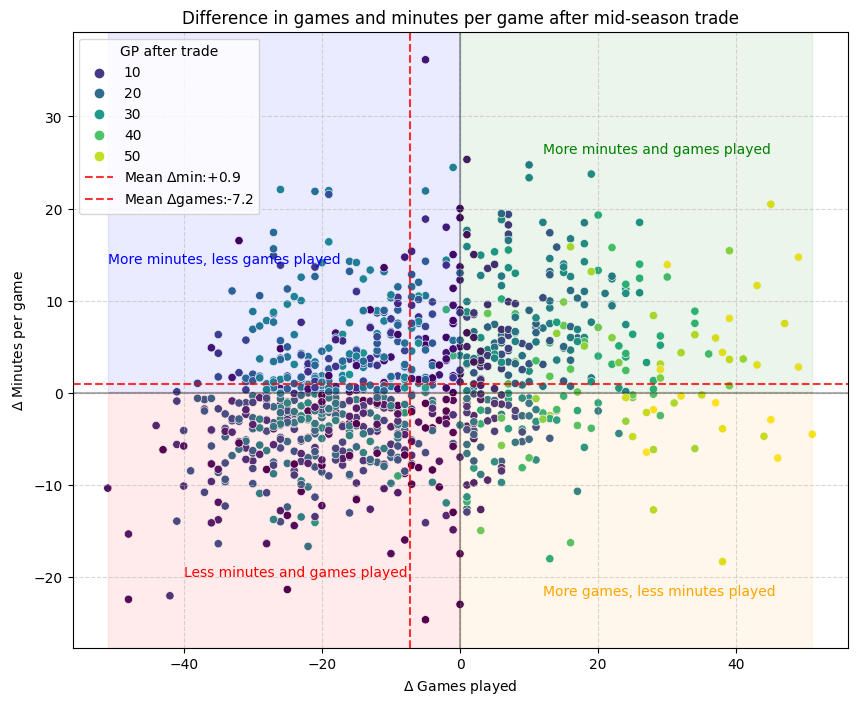

In [22]:
min_min = after_cases["d_MIN_PG"].min()
min_max = after_cases["d_MIN_PG"].max()
games_min = after_cases["d_GP"].min()
games_max = after_cases["d_GP"].max()

plt.figure(figsize=(10, 8))
sns_plot = sns.scatterplot(x="d_GP", y="d_MIN_PG", hue="GP", data=after_cases, palette="viridis");
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(y=d_mins_mean, color='r', linestyle='--', label=r'Mean $\Delta$min:' + f'+{d_mins_mean:.1f}', alpha=0.8)
plt.axvline(x=d_games_mean, color='r', linestyle='--', label=r'Mean $\Delta$games:' + f'{d_games_mean:.1f}', alpha=0.8)

plt.legend();

plt.axvspan(-51, 0, color='red', alpha=0.08, ymax=min_min/(min_min-min_max)+0.01)
plt.axvspan(-51, 0, color='blue', alpha=0.08, ymin=min_min/(min_min-min_max)+0.01)
plt.axvspan(0, 51, color='orange', alpha=0.08, ymax=min_min/(min_min-min_max)+0.01)
plt.axvspan(0, 51, color='green', alpha=0.08, ymin=min_min/(min_min-min_max)+0.01)


plt.title("Difference in games and minutes per game after mid-season trade");
#use delta letter for text on plot
plt.xlabel(r'$\Delta$ Games played')
plt.ylabel(r'$\Delta$ Minutes per game')
plt.text(-40, -20, r'Less minutes and games played', color='red')
plt.text(12, -22, r'More games, less minutes played', color='orange')
plt.text(-51, 14, r'More minutes, less games played', color='blue')
plt.text(12, 26, r'More minutes and games played', color='green');

handles, labels = sns_plot.get_legend_handles_labels()

order = [2,3,4,5,6,0,1]
sns_plot.legend(handles=[handles[i] for i in order], labels=[labels[i] for i in order], title="GP after trade");

### 2-a) Diff-in-diff

Here, we want to just check with a simple diff-in-diff model whether the in-season change in minutes played is different for traded players compared to non-traded players.

Because of the way the data is collected (there is no middle-of-the-season data for players that did not change teams), we have to assume a 0 effect in change for the control group. This is not ideal, but it is the best we can do with the data we have. We add every untreated instace as two instances, with one having AFTER = 0, other having AFTER = 1.

In [23]:
data_intervention_added = data_intervention.copy()
data_added = data[data["TRADED_THIS_SEASON"] == 0].copy()
data_added["AFTER"] = 0
data_added_2 = data_added.copy()
data_added_2["AFTER"] = 1
data_added = data_added.append(data_added_2, ignore_index=True)
data_intervention_added = data_intervention_added.append(data_added, ignore_index=True)

In [24]:
fit = smf.ols(f'{y} ~ TREATMENT + AFTER + TREATMENT*AFTER', data=data_intervention_added.dropna(subset=[y])).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     66.78
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           6.14e-43
Time:                        21:33:48   Log-Likelihood:                -67245.
No. Observations:               18131   AIC:                         1.345e+05
Df Residuals:                   18127   BIC:                         1.345e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          19.0360      0.156    122.133      0.000      18.730      19.341
TREATMENT           1.9910      0.209      9.536      0.000       1.582       2.400
AFTER            8.847e-14      0.220   4.01e-13      1.000      -0.432       0.432
TREATMENT:AFTER     0.1879      0.295      0.636      0.525      -0.391       0.767
==============================================================================
Omnibus:                     5097.614   Durbin-Watson:                   0.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.992
Skew:                           0.083   Prob(JB):                    2.16e-181
Kurtosis:                       1.964   Cond. No.                         7.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the treated players on average play 2 minutes more than nontreated players - this is surprising, as they are expected to play less due to them being treated. The average amount of minutes played is 19 minutes per game for the untreated group, which is quite low (one match is 48 minutes), which might suggest that non-starters bring down the average. The diff-in-diff estimate only adds 0.2 minutes per game, which is not significant.

In [25]:
smf_model = f"{y} ~ TREATMENT + AFTER + TREATMENT*AFTER + {t} + {x_l1} + {x_l2} + {x_le1} + \
            {z1} + {z2} + {z3} + {z4} + {z5} + {z6} + {z7} + \
            {z8} + {z9} + {z10} + {z11} + {z12} + {z13} + {z14} + \
            {t}*AFTER + {x_l1}*AFTER + {x_l2}*AFTER + {y_le1}*AFTER + \
            {z1}*AFTER + {z2}*AFTER + {z3}*AFTER + {z4}*AFTER + {z5}*AFTER + {z6}*AFTER + {z7}*AFTER + \
            {z8}*AFTER + {z9}*AFTER + {z10}*AFTER + {z11}*AFTER + {z12}*AFTER + {z13}*AFTER + {z14}*AFTER"
fit = smf.ols(smf_model, data=data_intervention_added.dropna(subset=[y])).fit()

print("Beta1:", fit.params["TREATMENT:AFTER"],)
fit.summary()

Beta1: 0.1942020625330754


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1050.
Date:                Sat, 01 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:34:02   Log-Likelihood:                -25813.
No. Observations:                9405   AIC:                         5.171e+04
Df Residuals:                    9364   BIC:                         5.200e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               5.1469      0.803      6.411      0.000       3.573       6.721
TREATMENT                               0.8498      0.134      6.324      0.000       0.586       1.113
AFTER                                  -1.0134      1.129     -0.897      0.370      -3.227       1.200
TREATMENT:AFTER                         0.1942      0.186      1.046      0.296      -0.170       0.558
time_trend                             -0.1331      0.026     -5.066      0.000      -0.185      -0.082
AFTER_N_MIDSEASON_TRADES_lag1           0.9754      0.210      4.653      0.000       0.564       1.386
AFTER_N_MIDSEASON_TRADES_lag2           0.4485      0.197      2.276      0.023       0.062       0.835
AFTER_N_MIDSEASON_TRADES_lead1         -1.6040      0.122    -13.198      0.000      -1.842      -1.366
AGE                                     0.2003      0.021      9.553      0.000       0.159       0.241
FG_PCT                                  4.4951      0.844      5.324      0.000       2.840       6.150
FG3_PCT                                -1.8481      0.426     -4.341      0.000      -2.683      -1.014
FT_PCT                                  0.4374      0.407      1.073      0.283      -0.361       1.236
PTS_PG                                  0.8691      0.015     56.668      0.000       0.839       0.899
AST_PM                                  4.8420      1.336      3.624      0.000       2.223       7.461
DREB_PM                                -2.1065      1.271     -1.658      0.097      -4.598       0.385
OREB_PM                                -1.0433      1.932     -0.540      0.589      -4.830       2.743
STL_PM                                 12.3387      4.128      2.989      0.003       4.246      20.431
BLK_PM                                 10.7945      3.628      2.975      0.003       3.683      17.906
TOV_PM                                -33.3159      2.987    -11.155      0.000     -39.170     -27.462
PF_PM                                 -27.1051      2.053    -13.200      0.000     -31.130     -23.080
NET_RATING_SEASON                      -0.0303      0.009     -3.506      0.000      -0.047      -0.013
NET_RATING_SEASON_lag1                  0.0280      0.009      3.215      0.001       0.011       0.045
time_trend:AFTER                       -0.0243      0.037     -0.655      0.513      -0.097       0.049
AFTER_N_MIDSEASON_TRADES_lag1:AFTER    -0.1904      0.262     -0.727      0.467      -0.703       0.323
AFTER_N_MIDSEASON_TRADES_lag2:AFTER     0.1739      0.291      0.598      0.550      -0.396       0.744
MIN_PG_lead1                            0.2764      0.009     29.969      0.000       0.258       0.294
MIN_PG_lead1:AFTER                      0.0152      0.013      1.15

Findings:

- Intercept decreased to just 4 minutes - the average that a no score, no foul etc. player would play per match
- Players that were traded played on average +0.85mins / match than those who were not traded - smaller effect than before, still significant
- Diff-in-diff: The coefficient grew to 0.194 minutes increase per match, similar to before. Nonsignificant, but an increase overall in time for being traded in the middle of the season. Lagged 1x -> increase in 0.97 minutes per match for each mid season trade in their career, and 2-times lagged values also add a 0.45 increase in minutes per match.
- Age: +0.2 for 1 year diff (significant), however, the number of seasons of a player counters with a decrease of -0.13.
- Field goal percentage: +4.5mins for each 1% increase in field goal percentage (significant)
- 3pointers%: Interestingly, the higher the %, the lower the minutes played, by -1.85 for each percentage (note that these percentages are in any case low). It might be because guards get traded more often, and guards score more 3-pointers, an indicator of position.

- Assist per min: Increase, for every 1 more assist per 10 minutes, an increase of playtime by 0.48 minutes (significant)
- Defensive rebounds per min: This confounder is on the border of being significant. Overall would be a positive statistic, but as a position indicator (guards, centers have high defensive rebounds), it also carries negative effects (forwards are usually the key players, who play the most), so overall a small, almost significant but negative impact. On the contrary, general (less related to position) defensive stats e.g. steals and blocks are significant and positive.
- Two very significant statistics, turnovers and personal fouls, and even the first difference in personal fouls, show how there is a bias against those who make mistakes, they are more likely to be not played.
- Net rating: significant, surprisingly decreases the played minutes per match, but the lagged version increases it: higher net rating before results in more minutes now.

Overall, the effect is nonsignificant, not even just in measuring the impact in one season.

### 2-b) Panel first differences

Here, we use a panel first differences model with time and entity fixed effects (which probably are not necessary, but can't hurt). In this case, we are interested in the long-term effect of being traded in the middle of the season on minutes played. The causal variable in this case is the number of mid-season trades a player has experienced.

In [29]:
model = f"{dy} ~ {dx} + {dt} + {dx_l1} + {dx_l2} + {dx_le1} + \
          {dz1} + {dz2} + {dz3} + {dz4} + {dz5} + {dz6} + {dz7} + \
          {dz8} + {dz9} + {dz10} + {dz11} + {dz12} + {dz13} + {dz14} \
          + TimeEffects + EntityEffects"
fit = PanelOLS.from_formula(model, 
    data=data.set_index(["PLAYER_ID", "YEAR"],).dropna(subset=[dy]+confounders),
    ).fit()
print("Beta1:", fit.params[dx], " with p-value:", fit.pvalues[dx])
fit.summary

Beta1: -0.07578150863488002  with p-value: 0.859886183399732


Dep. Variable:,d_MIN_PG,R-squared:,0.6670
Estimator:,PanelOLS,R-squared (Between):,0.7271
No. Observations:,4523,R-squared (Within):,0.6738
Date:,"Sat, Mar 01 2025",R-squared (Overall):,0.6848
Time:,21:47:59,Log-likelihood,-1.159e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,382.73
Entities:,1700,P-value,0.0000
Avg Obs:,2.6606,Distribution:,"F(19,3631)"
Min Obs:,0.0000,,
Max Obs:,18.000,F-statistic (robust):,382.73


We see that the effect is not significant - a coefficient of -0.07 with confidence interval going from -0.9 to 0.7 means that likely the effect is miniscule.

- The reverse-causality capturing lead tearm's coefficient is very significant - this makes sense, as the minutes played have an impact on being traded. The fact, that the other way around is not significant, means that there is no long-term impact of being traded on minutes played.
- The difference in field goal percentage, goals per game, assists per minute, are all significant. The free throw percentage change surprisingly also has a significant, but positive impact on difference in minutes played, which is hard to interpret. Possibly the good free throw shooters are the ones that are also good 3-point shooters, which are typically guards that are playing less minutes per match (due to their position).
- Change in age and experience are not significant confounders. Changes in 3-point percentages still have a negative coefficient, but are not statistically significant anymore.
- All changes in defensive statistics, except changes in defensive rebounds, are statistically significant.
- Changes in turnovers and personal fouls are still very significant with a negative impact on minutes played.
- Changes in net rating are not significant, but its lagged version is significant, with a positive impact on minutes played. This seems right, if the net rating increases then the player is more likely to play more minutes, appearantly this effect has a delay.

With R-squared of 68-69% for both the within and general R-squared, the model explains a lot of the variance in the data.

## 3 Robustness checks - starters vs. non-starters

There is a lot of difference if somebody gets traded to get more playtime, or someone who is already a starter gets traded. Let's analyze the two groups separately: anybody who started at least 50% of the matches in the season is considered a starter.

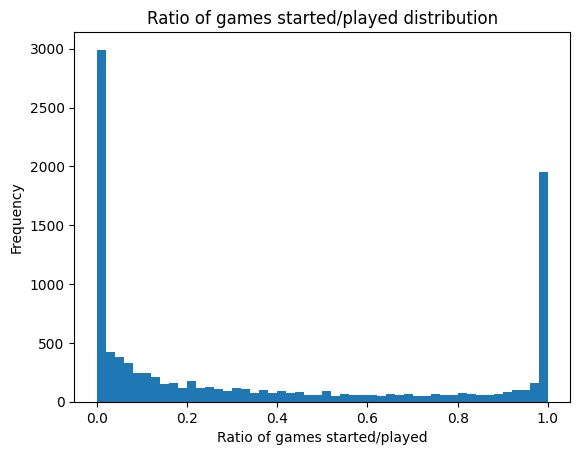

In [32]:
plt.hist(data['GS']/data['GP'], bins=50)
plt.title('Ratio of games started/played distribution')
plt.xlabel('Ratio of games started/played')
plt.ylabel('Frequency');

In [ ]:
data['STARTER'] = data['GS']/data['GP'] > 0.5
data_intervention_added['STARTER'] = data_intervention_added['GS']/data_intervention_added['GP'] > 0.5

In [33]:
model = f"{dy} ~ {dx} + {dt} + {dx_l1} + {dx_l2} + {dx_le1} + \
          {dz1} + {dz2} + {dz3} + {dz4} + {dz5} + {dz6} + {dz7} + \
          {dz8} + {dz9} + {dz10} + {dz11} + {dz12} + {dz13} + {dz14} \
          + TimeEffects + EntityEffects"
fit = PanelOLS.from_formula(model, 
    data=data[data['STARTER']==0].set_index(["PLAYER_ID", "YEAR"],).dropna(subset=[dy]+confounders),
    ).fit()
print("Beta1:", fit.params[dx], " with p-value:", fit.pvalues[dx])
fit.summary

Beta1: 0.15330411821488357  with p-value: 0.7500478412187075


Dep. Variable:,d_MIN_PG,R-squared:,0.7693
Estimator:,PanelOLS,R-squared (Between):,0.8149
No. Observations:,2362,R-squared (Within):,0.7694
Date:,"Szo, márc. 01 2025",R-squared (Overall):,0.7884
Time:,22:05:55,Log-likelihood,-5666.9
Cov. Estimator:,Unadjusted,,
,,F-statistic:,281.27
Entities:,1627,P-value,0.0000
Avg Obs:,1.4518,Distribution:,"F(19,1603)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,281.27


In [34]:
model = f"{dy} ~ {dx} + {dt} + {dx_l1} + {dx_l2} + {dx_le1} + \
          {dz1} + {dz2} + {dz3} + {dz4} + {dz5} + {dz6} + {dz7} + \
          {dz8} + {dz9} + {dz10} + {dz11} + {dz12} + {dz13} + {dz14} \
          + TimeEffects + EntityEffects"
fit = PanelOLS.from_formula(model, 
    data=data[data['STARTER']==1].set_index(["PLAYER_ID", "YEAR"],).dropna(subset=[dy]+confounders),
    ).fit()
print("Beta1:", fit.params[dx], " with p-value:", fit.pvalues[dx])
fit.summary

Beta1: 0.013666137920855918  with p-value: 0.9889775335860367


Dep. Variable:,d_MIN_PG,R-squared:,0.5708
Estimator:,PanelOLS,R-squared (Between):,0.5320
No. Observations:,2161,R-squared (Within):,0.5780
Date:,"Szo, márc. 01 2025",R-squared (Overall):,0.5479
Time:,22:06:09,Log-likelihood,-5038.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,111.22
Entities:,751,P-value,0.0000
Avg Obs:,2.8775,Distribution:,"F(19,1589)"
Min Obs:,0.0000,,
Max Obs:,16.000,F-statistic (robust):,111.22


Very interestingly, the results differ significantly from previous results!

- The lead term is no longer significant in either model, which is surprising as we would expect it to capture the reverse causality. It is still more significant for starters however.
- For non-starters (typically amateurs), difference in field goal percentages are significant, but for starters, the opposite are significant: three-point percentages, and free throws.
- Difference in age completely doesn't matter for non-starters, but for starters, it has a significant negative impact on minutes played, likely due to older players are utilized less and less over time.
- Points per game is very significant for both.
- Only certain defensive statistics are significant for non-starters, and for starters none are significant.
- Assists are only significant for starters.
- Turnovers and personal fouls are still significant for both groups.

#### Diff-in-diff for starters and non-starters

In [ ]:
smf_model = f"{y} ~ TREATMENT + AFTER + TREATMENT*AFTER + {t} + {x_l1} + {x_l2} + {x_le1} + \
            {z1} + {z2} + {z3} + {z4} + {z5} + {z6} + {z7} + \
            {z8} + {z9} + {z10} + {z11} + {z12} + {z13} + {z14} + \
            {t}*AFTER + {x_l1}*AFTER + {x_l2}*AFTER + {y_le1}*AFTER + \
            {z1}*AFTER + {z2}*AFTER + {z3}*AFTER + {z4}*AFTER + {z5}*AFTER + {z6}*AFTER + {z7}*AFTER + \
            {z8}*AFTER + {z9}*AFTER + {z10}*AFTER + {z11}*AFTER + {z12}*AFTER + {z13}*AFTER + {z14}*AFTER"
fit = smf.ols(smf_model, data=data_intervention_added[data_intervention_added['STARTER']==0].dropna(subset=[y])).fit()

print("Beta1:", fit.params["TREATMENT:AFTER"],)
fit.summary()

Beta1: 0.247925957865964


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     443.1
Date:              Szo, 01 márc. 2025   Prob (F-statistic):               0.00
Time:                        22:22:35   Log-Likelihood:                -12134.
No. Observations:                4795   AIC:                         2.435e+04
Df Residuals:                    4754   BIC:                         2.461e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               5.2098      0.828      6.295      0.000       3.587       6.832
TREATMENT                              -0.0765      0.162     -0.471      0.638      -0.395       0.242
AFTER                                  -0.9642      1.168     -0.825      0.409      -3.254       1.326
TREATMENT:AFTER                         0.2479      0.221      1.124      0.261      -0.185       0.680
time_trend                             -0.0487      0.030     -1.630      0.103      -0.107       0.010
AFTER_N_MIDSEASON_TRADES_lag1           0.8276      0.210      3.946      0.000       0.416       1.239
AFTER_N_MIDSEASON_TRADES_lag2           0.1114      0.199      0.559      0.577      -0.279       0.502
AFTER_N_MIDSEASON_TRADES_lead1         -0.9861      0.124     -7.924      0.000      -1.230      -0.742
AGE                                     0.1444      0.024      6.088      0.000       0.098       0.191
FG_PCT                                 -0.5127      0.794     -0.646      0.518      -2.069       1.043
FG3_PCT                                -2.0112      0.452     -4.446      0.000      -2.898      -1.124
FT_PCT                                  0.3683      0.374      0.984      0.325      -0.365       1.102
PTS_PG                                  1.3478      0.024     56.454      0.000       1.301       1.395
AST_PM                                  4.3280      1.567      2.762      0.006       1.256       7.400
DREB_PM                                -2.6028      1.378     -1.889      0.059      -5.304       0.099
OREB_PM                                -4.3975      1.716     -2.562      0.010      -7.762      -1.033
STL_PM                                  8.2291      4.057      2.029      0.043       0.276      16.182
BLK_PM                                  9.4590      3.872      2.443      0.015       1.869      17.049
TOV_PM                                -22.6117      2.754     -8.210      0.000     -28.011     -17.212
PF_PM                                  -8.7524      1.912     -4.577      0.000     -12.501      -5.003
NET_RATING_SEASON                      -0.0133      0.008     -1.603      0.109      -0.030       0.003
NET_RATING_SEASON_lag1                  0.0336      0.009      3.782      0.000       0.016       0.051
time_trend:AFTER                       -0.0313      0.042     -0.737      0.461      -0.115       0.052
AFTER_N_MIDSEASON_TRADES_lag1:AFTER    -0.1661      0.268     -0.619      0.536      -0.692       0.360
AFTER_N_MIDSEASON_TRADES_lag2:AFTER     0.1141      0.297      0.384      0.701      -0.468       0.697
MIN_PG_lead1                            0.1241      0.010     12.392      0.000       0.104       0.144
MIN_PG_lead1:AFTER                      0.0104      0.014      0.72

In [37]:
data_intervention_added['STARTER'] = data_intervention_added['GS']/data_intervention_added['GP'] > 0.5
smf_model = f"{y} ~ TREATMENT + AFTER + TREATMENT*AFTER + {t} + {x_l1} + {x_l2} + {x_le1} + \
            {z1} + {z2} + {z3} + {z4} + {z5} + {z6} + {z7} + \
            {z8} + {z9} + {z10} + {z11} + {z12} + {z13} + {z14} + \
            {t}*AFTER + {x_l1}*AFTER + {x_l2}*AFTER + {y_le1}*AFTER + \
            {z1}*AFTER + {z2}*AFTER + {z3}*AFTER + {z4}*AFTER + {z5}*AFTER + {z6}*AFTER + {z7}*AFTER + \
            {z8}*AFTER + {z9}*AFTER + {z10}*AFTER + {z11}*AFTER + {z12}*AFTER + {z13}*AFTER + {z14}*AFTER"
fit = smf.ols(smf_model, data=data_intervention_added[data_intervention_added['STARTER']==1].dropna(subset=[y])).fit()

print("Beta1:", fit.params["TREATMENT:AFTER"],)
fit.summary()

Beta1: 0.013285752456208388


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     344.2
Date:              Szo, 01 márc. 2025   Prob (F-statistic):               0.00
Time:                        22:22:47   Log-Likelihood:                -10936.
No. Observations:                4610   AIC:                         2.195e+04
Df Residuals:                    4569   BIC:                         2.222e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              19.2593      1.108     17.385      0.000      17.087      21.431
TREATMENT                               0.4876      0.128      3.821      0.000       0.237       0.738
AFTER                                   0.8828      1.578      0.560      0.576      -2.210       3.976
TREATMENT:AFTER                         0.0133      0.178      0.075      0.941      -0.336       0.363
time_trend                             -0.2813      0.026    -10.753      0.000      -0.333      -0.230
AFTER_N_MIDSEASON_TRADES_lag1           0.4108      0.249      1.647      0.100      -0.078       0.900
AFTER_N_MIDSEASON_TRADES_lag2          -0.1586      0.230     -0.689      0.491      -0.610       0.293
AFTER_N_MIDSEASON_TRADES_lead1         -0.4122      0.145     -2.838      0.005      -0.697      -0.127
AGE                                     0.1731      0.021      8.168      0.000       0.132       0.215
FG_PCT                                 -2.1721      1.314     -1.653      0.098      -4.748       0.404
FG3_PCT                                -0.4036      0.480     -0.840      0.401      -1.345       0.538
FT_PCT                                 -1.6712      0.660     -2.531      0.011      -2.965      -0.377
PTS_PG                                  0.4588      0.017     27.580      0.000       0.426       0.491
AST_PM                                  5.1567      1.488      3.465      0.001       2.239       8.075
DREB_PM                                -0.3719      1.488     -0.250      0.803      -3.289       2.545
OREB_PM                                 5.8446      3.380      1.729      0.084      -0.783      12.472
STL_PM                                 23.0829      5.129      4.501      0.000      13.028      33.138
BLK_PM                                  5.2420      3.921      1.337      0.181      -2.445      12.929
TOV_PM                                -22.4793      4.547     -4.944      0.000     -31.393     -13.566
PF_PM                                 -47.3577      3.211    -14.749      0.000     -53.653     -41.063
NET_RATING_SEASON                      -0.0340      0.011     -2.978      0.003      -0.056      -0.012
NET_RATING_SEASON_lag1                 -0.0126      0.010     -1.238      0.216      -0.033       0.007
time_trend:AFTER                       -0.0178      0.037     -0.483      0.629      -0.090       0.054
AFTER_N_MIDSEASON_TRADES_lag1:AFTER    -0.2279      0.300     -0.759      0.448      -0.817       0.361
AFTER_N_MIDSEASON_TRADES_lag2:AFTER     0.3414      0.334      1.023      0.306      -0.313       0.995
MIN_PG_lead1                            0.2545      0.010     24.276      0.000       0.234       0.275
MIN_PG_lead1:AFTER                     -0.0163      0.015     -1.10

## 4. Conclusion

Likely there are omitted variable biases that we didn't capture, as there is mixed results for different attributes and settings (e.g. the starter vs. nonstarter example). Overall, the effect is not significant neither in the season when it happens, although might have a slight increase, nor in the long term.